# Resultados Obtidos
Este *notebook* apresenta os resultados obtidos ao aplicar o desagregador *Sparse NILM* proposto em Makonin et al. com os dados de consumo da base de dados REDD.

Foram realizadas alterações no *Sparse NILM*:
- Uso de distribuição gaussiana para estimação das funções massa de probabilidade, tornando a desagregação mais robusta a ruídos
- Separação das funções em módulos, facilitando o seu uso



# Referências
S. Makonin, F. Popowich, I. V. Bajic, B. Gill, and L. Bartram, “Exploiting HMM Sparsity to Perform Online Real-Time Nonintrusive Load Monitoring,” IEEE Trans. Smart Grid, vol. 7, no. 6, pp. 2575–2585, 2016, doi: 10.1109/TSG.2015.2494592.

Código-fonte: https://github.com/smakonin/SparseNILM (foram realizadas modificações para importação como módulo e visualização de resultados)

In [1]:
import io
import sys
import pandas as pd
from matplotlib import pyplot as plt
sys.path.append(r'./src')
import wrapper

# Treinamento
Sobre o algoritmo de desagregação:
- Problema exponencial do Factorial Hidden Markov Model (FHMM) - sendo $N$ o número de aplicações, o número de estados é exponencial: $2^N$ (considerando apenas aplicações com estados ON-OFF)

- Para contornar esse problema, usa algoritmo de Viterbi para transições esparsas para tornar a complexidade computacional linear em relação a $N$, permitindo maior número de aplicações monitoradas

- Foram feitas mudanças no código fonte (adicionada nova classe `wrapper`) para facilitar chamada de funções pelo Google Colab

## Algoritmo de Viterbi
Dado um modelo HMM e uma série de valores observáveis, qual a série de estados escondidos com a maior probabilidade de ocorrência?

https://medium.com/analytics-vidhya/viterbi-algorithm-for-prediction-with-hmm-part-3-of-the-hmm-series-6466ce2f5dc6

## Viterbi para transições esparsas
As aplicações são modeladas como funções de densidade de probabilidade (PDF) normais com média igual ao seu consumo no estado ON.

Considerando a potência consumida atualmente $\Delta P$, são consideradas apenas as PDFs cujas médias são mais próximas de $\Delta P$.

Considerando ainda que as PDFs foram ordenadas em função de seus consumos médios, a aplicação $i$ só pode ser confundida com as aplicações $i-1$ e $i+1$.

Deste modo, a matriz de transição de próximo estado é esparsa com zeros para as demais PDFs.

In [2]:
path = r'./data/'
modeldb = 'Minute_L01_REDD'
dataset = 'house_1'
precision = 10e0
max_obs = 5*10e3
denoised = 'noisy'
max_states = 4
folds = 10
ids = 'fridge,light,microwave,dish washer'
wrapper.train(path, modeldb, dataset, precision, max_obs, denoised, max_states, folds, ids)


Loading REDD Low Res dataset at ./data//datasets/house_1.csv...


FileNotFoundError: [Errno 2] File b'./data//datasets/house_1.csv' does not exist: b'./data//datasets/house_1.csv'

# Métricas utilizadas
São utilizadas 3 métricas para analisar a desagregação obtida:
- Acurácia do estado do eletrodoméstico
- Acurácia do consumo energético
- Finite State f-Score

## Acurácia do Estado do Eletrodoméstico
Porcentagem dos estados predizidos corretamente

**Vantagens**
- Mais utilizada em artigos
- Fácil entendimento

**Desvantagens**
- O uso de eletrodomésticos é esporádico
- Predizer que uma aplicação está sempre desligada obtêm alta acurácia

## Acurácia do Consumo Energético
Porcentagem do consumo total predizido corretamente

$$Est. Acc.=1 - \frac{\sum_{t=1}^T \sum_{m=1}^M|\hat{y}_t^{(m)}-y_t^{(m)}|}{2 \times \sum_{t=1}^T \sum_{m=1}^My_t^{(m)}}$$

$T$: período de validação

$M$: número de aplicações analisadas

$\hat{y}_t^{(m)}$: consumo estimado da aplicação $m$ no instante $t$

$y_t^{(m)}$: consumo real da aplicação $m$ no instante $t$

**Vantagens**

Favorece soluções que focam em dois casos de uso:
- Educa o usuário sobre a composição da conta de luz
- Estimativas de quanto (em kWh) será salvo adotando ações de economia

**Desvantagem**
- Aparelhos com maior consumo têm maior influência na métrica

## Finite State f-Score
- f-score (média harmônica entre precision e recall) permite apenas classificações binárias
- FS f-score permite classificação não binária

**Vantagens**
- Predizer que uma aplicação está sempre desligada obtêm f-score baixo
- Aparelhos com menor consumo têm a mesma influência na métrica

**Desvantagem**
- Pouco usado em artigos

In [3]:
test_id = 'Wiseful_Hourly_L03'
measure = 'Wh'
limit = 'all'
algo_name = 'SparseViterbi'
true_states, pred_states, true_y, pred_y = wrapper.test(test_id, path, modeldb, dataset, precision, measure, denoised, limit, algo_name)

true_y *= 0.1
# pred_y *= max_obs / 10000

Loading Wiseful dataset at /content/drive/My Drive/Wiseful/Arquivados/Código/Sparse_NILM//datasets/victor.csv...
	Setting timestamp column Timestamp as index.
	Modfity data with precision 10.000000 then convert to int...
	Keeping only columns ['ch3', 'ch4', 'ch5'].
	Calculating unmetered column unmetered.

Created 10 folds: [440, 440, 440, 440, 440, 440, 440, 440, 440, 443].


************************ VALIDATION ROUND:  1/10 ************************

Building priors and testing datasets...
	Lengths are: priors 3963, testing 440.
	Completed  1/10: [====================], Disagg rate:     0.000036 sec/sample 

************************ VALIDATION ROUND:  2/10 ************************

Building priors and testing datasets...
	Lengths are: priors 3963, testing 440.
	Completed  2/10: [====================], Disagg rate:     0.000044 sec/sample 

************************ VALIDATION ROUND:  3/10 ************************

Building priors and testing datasets...
	Lengths are: priors 3963, testin

# Visualização dos Resultados
Quanto menor o consumo, mais difícil é realizar a desagregação do eletrodoméstico.

**Obs:** A entrada é o consumo total da residência. É mostrado o consumo individual apenas para comparação com os estados predizidos.


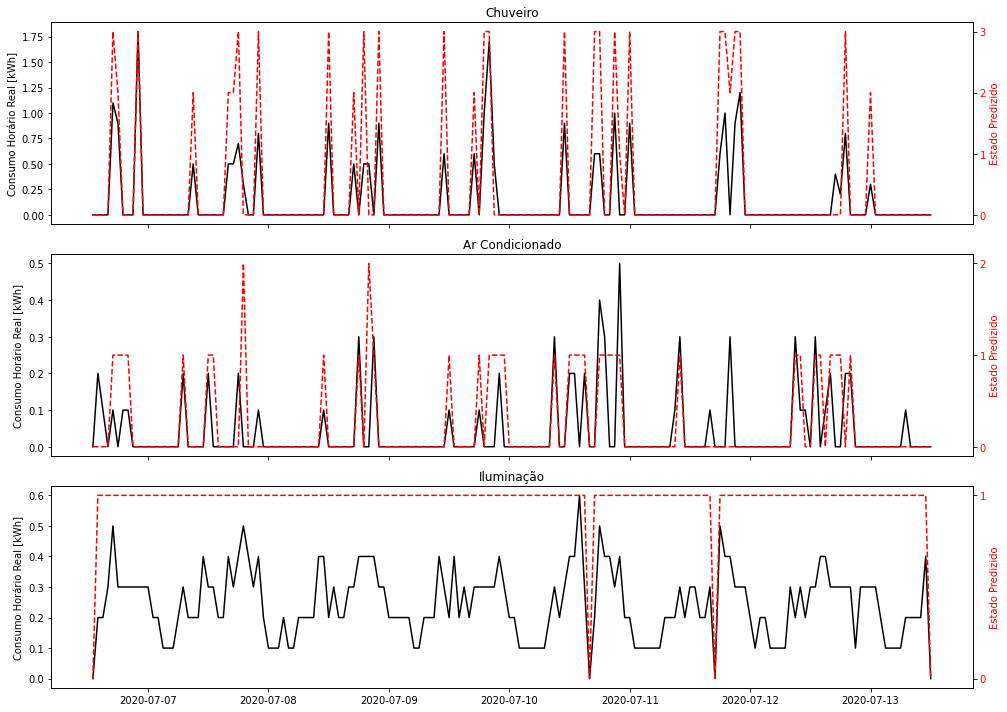

In [4]:
from matplotlib.ticker import MaxNLocator

# Visualiza a 1a semana
start = 24 * 7 * 0
end = 24 * 7 * 1

df = pd.read_csv(path + 'datasets/victor.csv', index_col=0)
df.dropna(inplace=True)
df.index = pd.to_datetime(df.index)
index = df.index.values[-true_states.shape[0]:]
del df

fig, axs = plt.subplots(3, figsize=(14,10), sharex=True)

labels = ['Chuveiro', 'Ar Condicionado', 'Iluminação']
for i in range(3):
    axs[i].set_title(labels[i])
    axs[i].plot(index[start:end], true_y[start:end, i], color='black')
    axs[i].tick_params(axis='y', labelcolor='black')
    axs[i].set_ylabel('Consumo Horário Real [kWh]', color='black')

    ax_twin = axs[i].twinx()  # Cria plots com escalas y diferentes
    ax_twin.plot(index[start:end], pred_states[start:end, i], '--', color='red')
    ax_twin.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_twin.tick_params(axis='y', labelcolor='red')
    ax_twin.set_ylabel('Estado Predizido', color='red')

fig.tight_layout()
plt.show()

# Visualização de todos os dados de validação

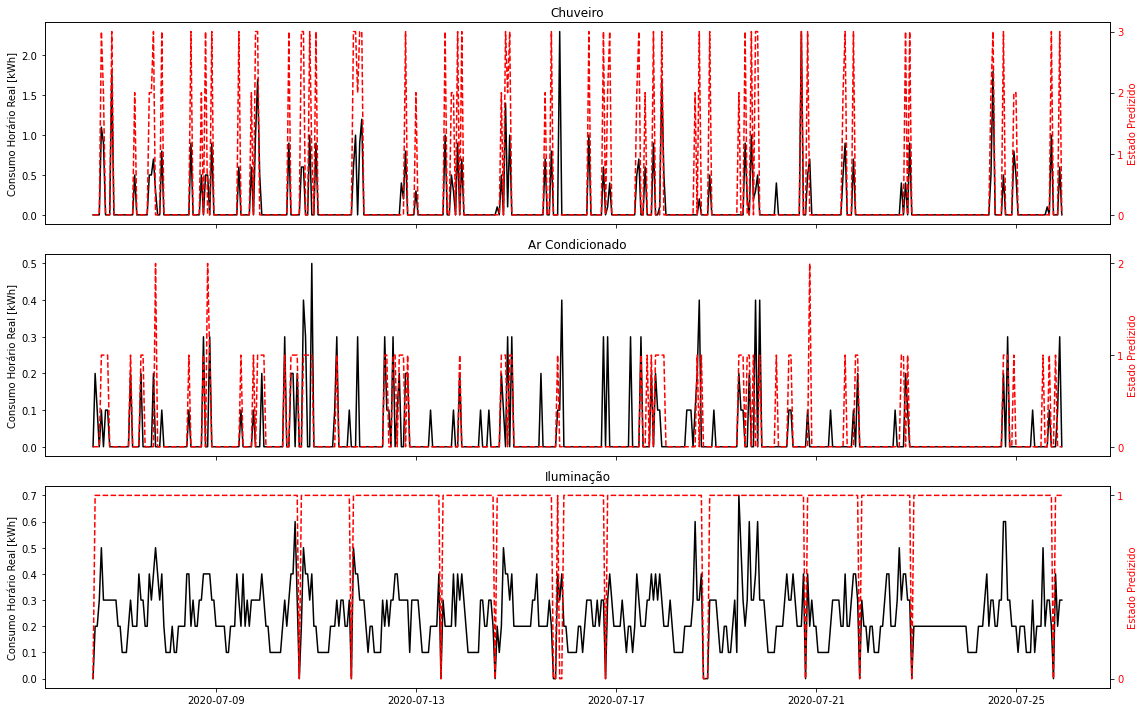

In [5]:
from matplotlib.ticker import MaxNLocator

# Visualiza todo o 10o fold de validacao cruzada
start = 0
end = -1

df = pd.read_csv(path + 'datasets/victor.csv', index_col=0)
df.dropna(inplace=True)
df.index = pd.to_datetime(df.index)
index = df.index.values[-true_states.shape[0]:]
del df

fig, axs = plt.subplots(3, figsize=(16,10), sharex=True)

labels = ['Chuveiro', 'Ar Condicionado', 'Iluminação']
for i in range(3):
    axs[i].set_title(labels[i])
    axs[i].plot(index[start:end], true_y[start:end, i], color='black')
    axs[i].tick_params(axis='y', labelcolor='black')
    axs[i].set_ylabel('Consumo Horário Real [kWh]', color='black')

    ax_twin = axs[i].twinx()  # Cria plots com escalas y diferentes
    ax_twin.plot(index[start:end], pred_states[start:end, i], '--', color='red')
    ax_twin.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_twin.tick_params(axis='y', labelcolor='red')
    ax_twin.set_ylabel('Estado Predizido', color='red')

fig.tight_layout()
plt.show()